In [1]:
import re
import csv
# import nltk
import string
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

2024-03-16 02:51:01.312752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 02:51:01.312849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 02:51:01.496447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Confirm that the GPU is detected
torch.cuda.is_available()

True

In [3]:
# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 2


In [67]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Loading the dataset

In [ ]:
tweet_df = pd.read_csv("/kaggle/input/processed-data/Preprocessed_Data_Final.csv")

# AAE-to-SAE translation using MBart

In [93]:
def translate_aae_to_sae(sentence, model, tokenizer, device='cuda'):
    # Move the model to the specified device
    model.to(device)

    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move the input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate translation output
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=256,
    )

    # Decode the output
    translated_sentence = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return translated_sentence

In [165]:
filename1 = 'mbart_translate_5epochs.sav'

In [166]:
# Load the model from disk

fpath1 = '/kaggle/working/' + filename1
translation_model = pickle.load(open(fpath1, 'rb'))

### Demo: AAE to SAE translation using MBart 

In [170]:
aae_sentence = "Where you been"
sae_translation = translate_aae_to_sae(aae_sentence, translation_model, tokenizer)
print(f"AAE: {aae_sentence}\nSAE: {sae_translation}")

AAE: Where you been
SAE:  September been


In [171]:
aae_sentence = "Boy you can say anything you wanna I don't give a shit, noone else can have ya"
sae_translation = translate_aae_to_sae(aae_sentence, translation_model, tokenizer)
print(f"AAE: {aae_sentence}\nSAE: {sae_translation}")

AAE: Boy you can say anything you wanna I don't give a shit, noone else can have ya
SAE: Boy you can say anything you wanna I don't give a shit, noone else can have ya


## Use this model to translate AAE samples in our data 

In [ ]:
tweet_df = pd.read_csv("/kaggle/input/processed-data/Preprocessed_Data_Final.csv")

In [ ]:
tweet_df = tweet_df.rename(columns={'new_class': 'label', 'cleaned_tweet': 'clean_tweet'})

In [ ]:
tweet_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
tweet_df.head()

In [ ]:
def apply_translation(row):
    if row['AAVE'] == 1:
        return translate_aae_to_sae(row['clean_tweet'], translation_model, tokenizer)
    else:
        return row['clean_tweet']

In [ ]:
tweet_df['SAE_tweet'] = tweet_df.apply(apply_translation, axis=1)

In [ ]:
tweet_df.isnull().sum()

In [ ]:
tweet_df.dropna(inplace = True)

In [ ]:
tweet_df.isnull().sum()

In [ ]:
tweet_df.to_csv('processed_tweets_with_sae.csv')

# Use DistilRoBERTa model to detect hate speech

In [4]:
data = pd.read_csv('/kaggle/working/processed_tweets_with_sae.csv')

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

2024-03-14 03:20:59.543195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 03:20:59.543295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 03:20:59.697407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")

In [23]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Prediction on original data (with AAE text samples)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)

# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['clean_tweet'])
test_encodings = tokenize_data(X_test['clean_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

In [26]:
len(train_dataset), len(test_dataset)

(19826, 4957)

In [27]:
X_test.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,AAVE_hate_speech,AAVE,label,clean_tweet,SAE_tweet
2281,2281,3,0,3,0,1,934 8616\ni got a missed call from yo bitch,0,0,0,i got a missed call from yo bitch,i got a missed call from yo bitch
15914,15915,6,0,6,0,1,RT @KINGTUNCHI_: I don't understand if all the...,0,0,0,RT : I don't understand if all these hoes say ...,RT : I don't understand if all these hoes say ...
18943,18944,6,1,5,0,1,RT @eanahS__: I done had EVERYTHING you hoes e...,0,1,0,RT : I done had EVERYTHING you hoes ever wante...,RT: I done had EVERYTHING you hoes ever wanted...
16407,16408,3,0,3,0,1,RT @MayaAngelouFRO: Ready to slay these bitche...,0,0,0,RT : Ready to slay these bitches and im not ev...,RT : Ready to slay these bitches and im not ev...
13326,13327,3,0,3,0,1,Niggas cry when they get hit high and cry when...,0,0,0,Niggas cry when they get hit high and cry when...,Niggas cry when they get hit high and cry when...


In [134]:
num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()  # Takes ~10 minutes to run for 5 epochs over ~19.8k training samples

In [ ]:
trainer.evaluate()

In [113]:
filename2 = 'distilroberta_base_5epochs.sav'

In [112]:
# Save the model to disk
pickle.dump(model, open(filename2, 'wb'))

In [135]:
# Load the model from disk
fname = "/kaggle/input/model-file-1/distilroberta_base_5epochs.sav"
loaded_model = pickle.load(open(fname, 'rb'))

In [136]:
trainer = Trainer(
    model=loaded_model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [137]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


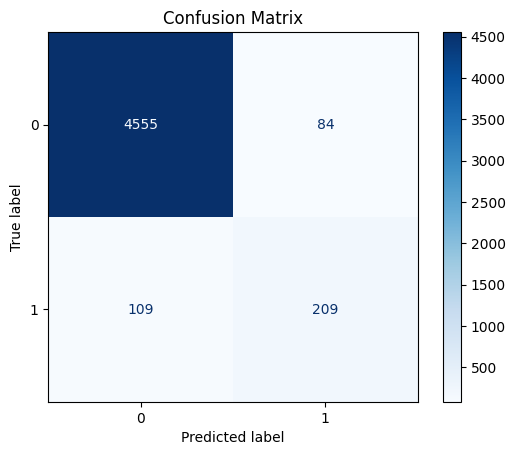

In [138]:
true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [139]:
accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR}")

Accuracy: 0.9610651603792616
False Positive Rate: 0.018107350722138392


### Predict on processed data (with translated SAE text samples)

In [140]:
# X_train, X_test, y_train, y_test = train_test_split(tweet_df,tweet_df['new_class'], test_size=0.4,random_state=42)
# train_encodings = tokenize_data(X_train['SAE_tweet'])
test_encodings = tokenize_data(X_test['SAE_tweet'])
# y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


# train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

In [141]:
len(train_dataset), len(test_dataset)

(19826, 4957)

In [ ]:
num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [142]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


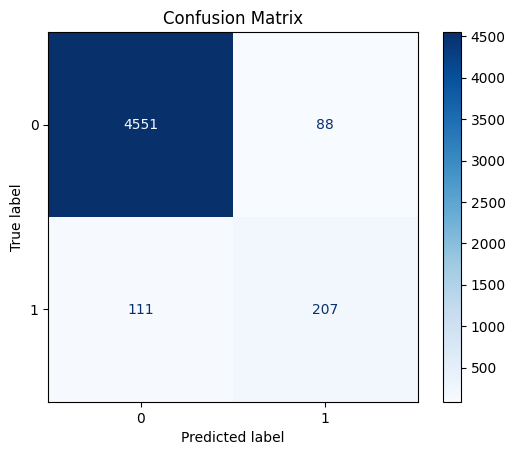

In [143]:
true_labels = predictions.label_ids
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [144]:
accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")
# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR}")

Accuracy: 0.9598547508573734
False Positive Rate: 0.018969605518430695


## Test on AAE tweet data

In [145]:
aae_data = tweet_df[tweet_df['AAVE']==1]

In [146]:
len(aae_data)

1201

In [147]:
aae_data.head()

,count,hate_speech,offensive_language,neither,class,tweet,AAVE_hate_speech,AAVE,label,clean_tweet,SAE_tweet
25,3,0,2,1,1,""" her pussy lips like Heaven doors "" &#128524;",0,1,0,""" her pussy lips like Heaven doors ""","\""She's acting with her pussy lips like she's ..."
32,3,0,3,0,1,""" if you aint bout that Murder Game pussy nigg...",0,1,0,""" if you aint bout that Murder Game pussy nigg...","\""If you are not interested in that murder gam..."
36,3,0,3,0,1,""" it aint nothing to cut a bitch off """,0,1,0,""" it aint nothing to cut a bitch off ""","\""It's not nothing to cut a bitch off\"""
51,3,0,3,0,1,""" yall niggas b cuffing hoes cause yall aint n...",0,1,0,""" yall niggas b cuffing hoes cause yall aint n...","\""You all have sex with whores because you wil..."
54,3,0,2,1,1,"""&#128514;&#128514;&#128514;&#128514;&#128514;...",0,1,0,""" Teanna Trump probably cleaner than most of t...",Teanna Trump is probably cleaner than most of ...


In [148]:
y_test = aae_data['label']
y_test_tensor = torch.tensor(y_test.values)

In [149]:
test_encodings1 = tokenize_data(aae_data['clean_tweet'])
test_encodings2 = tokenize_data(aae_data['SAE_tweet'])

test_dataset1 = TextDataset(test_encodings1, y_test_tensor)
test_dataset2 = TextDataset(test_encodings2, y_test_tensor)

In [151]:
len(test_dataset1), len(test_dataset2)

(1201, 1201)

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


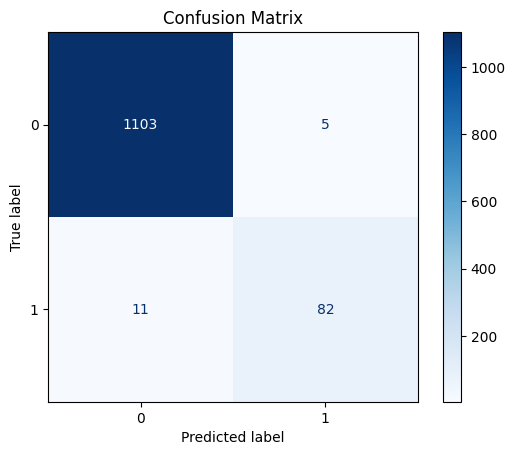

Accuracy: 0.9866777685262281
False Positive Rate: 0.004512635379061372


In [153]:
predictions1 = trainer.predict(test_dataset1)
preds1 = np.argmax(predictions1.predictions, axis=-1)

true_labels1 = predictions1.label_ids
cm = confusion_matrix(true_labels1, preds1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy1 = accuracy_score(true_labels1, preds1)
print(f"Accuracy: {accuracy1}")
# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FPR1 = FP / float(FP + TN)  # FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR1}")

/tmp/ipykernel_34/2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_34/2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


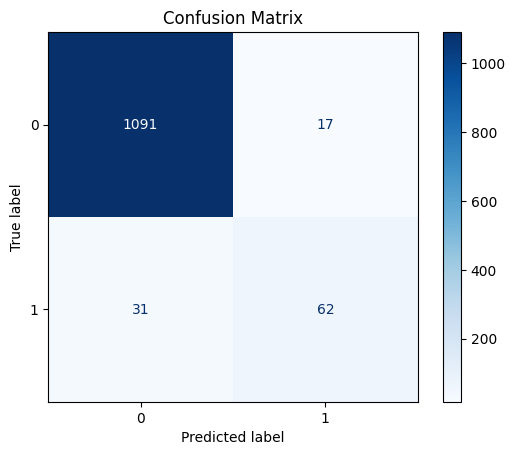

Accuracy: 0.9600333055786844
False Positive Rate: 0.015342960288808664


In [154]:
predictions2 = trainer.predict(test_dataset2)
preds2 = np.argmax(predictions2.predictions, axis=-1)

true_labels2 = predictions2.label_ids
cm = confusion_matrix(true_labels2, preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

accuracy2 = accuracy_score(true_labels2, preds2)
print(f"Accuracy: {accuracy2}")
# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FPR2 = FP / float(FP + TN)  # FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR2}")

# Fine-tuning DistilRoberta-base 

In [16]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn import functional as F

import transformers 
from transformers.models.bert.modeling_bert import BertEmbeddings, BertModel, BertPreTrainedModel
from transformers import RobertaConfig, RobertaModel
from transformers.file_utils import add_start_docstrings

In [17]:
ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP = {
    'roberta-base': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin",
    'roberta-large': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-pytorch_model.bin",
    'roberta-large-mnli': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-pytorch_model.bin",
    'distilroberta-base': "https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-pytorch_model.bin",
    'roberta-base-openai-detector': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-pytorch_model.bin",
    'roberta-large-openai-detector': "https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-pytorch_model.bin",
}

In [28]:
class RobertaForDebiasSequenceClassification(BertPreTrainedModel):
    
    config_class = RobertaConfig
    pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "roberta"

    def __init__(self, config):
        super(RobertaForDebiasSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)
        
        self.bias_lin = torch.nn.Linear(1024, 1)
    
    def debias_loss(self, hidden, logits, bias, labels, penalty=0.01):

        logits = logits.float()  # In case we were in fp16 mode
        hidden = hidden[:, 0, :] # Take <s>, the same as CLS token
        logits = F.log_softmax(logits, 1)

        factor = self.bias_lin.forward(hidden)
        factor = factor.float()
        factor = F.softplus(factor)
        bias = bias * factor

        bias_lp = F.log_softmax(bias, 1)
        entropy = -(torch.exp(bias_lp) * bias_lp).sum(1).mean(0)

        loss = F.cross_entropy(logits + bias, labels) + penalty*entropy
        return loss
        #return loss, logits+bias

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None,
                labels=None, bias=None):
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask,
                               inputs_embeds=inputs_embeds)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]
        #outputs = outputs[2:]
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            elif bias is None:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            else:
                loss = self.debias_loss(sequence_output, logits, bias, labels)
            outputs = (loss,) + outputs
            #outputs = (loss, logits_bias,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [29]:
class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super(RobertaClassificationHead, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [ ]:
num_labels = 2  # Adjust based on your task
model = RobertaForDebiasSequenceClassification("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Training Parameters 

FT_EPOCHS = 4
BATCH_SIZE = 64
NUM_STEPS = len(X_train.index)

In [ ]:
# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss=focal_loss(),
              metrics=['accuracy'])

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=2
)

In [21]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", device_map="auto")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")

In [23]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)

# Tokenize the training and testing data
train_encodings = tokenize_data(X_train['clean_tweet'])
test_encodings = tokenize_data(X_test['clean_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

In [34]:
len(train_dataset), len(test_dataset)

(19826, 4957)

In [37]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 128


import tensorflow as tf 

# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train['clean_tweet'].tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test['clean_tweet'].tolist())

# Adverserial training 

In [1]:
import time
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, AdamW, DistilBertModel, DistilBertConfig

In [2]:
def get_max_len(tokenizer, tweets):
    max_length = 0
    for t in tweets:
      ids = tokenizer.encode(t)
      max_length = max(len(ids),max_length)
    return max_length if max_length <= 512 else 512 # The max sequence length for BERT is 512


def tokenize_for_tweet(tokenizer, tweets, labels, max_length):
    input_ids = []
    attention_masks = []

    for t in tweets:
        input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        input_ids.append(input_dict['input_ids'])
        attention_masks.append(input_dict['attention_mask'])
    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels=torch.tensor(labels)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset


def run_tokenizer(data, x_col='clean_tweet', y_col='label', test_size=0.3):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
    
    X_train, X_test, y_train, y_test = train_test_split(data, data[y_col], test_size=test_size, random_state=42)
    train_tweets = X_train[x_col].values
    test_tweets = X_test[x_col].values
    train_labels = y_train.values
    test_labels = y_test.values
    
    max_length = get_max_len(tokenizer, train_tweets)
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels, max_length)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels, max_length)
    
    return train_dataset, test_dataset, tokenizer

In [3]:
data_df = pd.read_csv('/kaggle/working/processed_tweets_with_sae.csv')
data = data_df[data_df["AAVE"]==1]
len(data)

1201

In [4]:
train_dataset, test_dataset, tokenizer = run_tokenizer(data, x_col='clean_tweet', 
                                                       y_col='label', test_size=0.3)
len(train_dataset), len(test_dataset)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

(840, 361)

In [5]:
# Make data loader
batch_size = 20
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [6]:
# Define classifier and adversary
configuration = DistilBertConfig()


class Classifier(nn.Module):
  def __init__(self, num_label):
    super().__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-cased')
    self.linear = nn.Linear(configuration.hidden_size, num_label)

  def forward(self, input_ids, attention_mask): # input_id [batch_size, sentence_length]
    last_hidden_state = self.bert(input_ids, attention_mask)[0] # last_hidden_state [batch_size, sentence_length, hidden_size]
    last_hidden_state_mean = torch.mean(last_hidden_state, dim=1) # last_hidden_state [batch_size, hidden_size]
    output = self.linear(last_hidden_state_mean) # output [batch_size, num_label]
    return last_hidden_state, last_hidden_state_mean, output


class Adversary(nn.Module):
  def __init__(self, num_protected_label, hidden_size):
    super().__init__()
    self.linear1 = nn.Linear(configuration.hidden_size, hidden_size)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_size, num_protected_label)

  def forward(self, clf_last_state):
    output1 = self.linear1(clf_last_state)
    output1_relu = self.relu(output1)
    output = self.linear2(output1_relu)
    return output


def evaluate(clf, test_dataloader):
    num_total, num_correct = 0, 0
    clf.train(False)
    
    with torch.no_grad():
        eval_loss = 0
        true_labels, predict_labels = [], []
        for input, mask, label in test_dataloader:
            clf.zero_grad()
            
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label = label.to(DEVICE)

            last_hidden_state, last_hidden_state_mean, output = clf(input_ids=input, 
                                                                    attention_mask=mask)
            loss = loss_function(output, label)
            predict_label = torch.argmax(output, dim=1)

            true_labels += label.tolist()
            predict_labels += predict_label.tolist()

            num_correct += (predict_label == label).sum().item()
            num_total += len(label)

            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(test_dataloader)
        acc = num_correct/num_total
    
    print('average eval_loss: {}, accuracy: {}'.format(avg_eval_loss,acc))
    
    
def joint_training(clf, adv, epochs, clf_optimizer, adv_optimizer, train_dataloader, test_dataloader, alpha):
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss, total_clf_loss, total_adv_loss = 0, 0, 0

        clf.train(True)
        adv.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label = label.to(DEVICE)
            print("label shape:", label.shape)
            
            # Make protected labels
            protected_label = torch.tensor([1 if l == 1 else 0 for l in label], dtype=torch.long).to(DEVICE) # 0 no-offensive 1 offensive
            print("protected_label shape:", protected_label.shape)
            
            clf.zero_grad()
            adv.zero_grad()
            
            last_hidden_state, last_hidden_state_mean, clf_output = clf(input_ids=input, attention_mask=mask)
            print("clf_output shape:", clf_output.shape)

            adv_output = adv(last_hidden_state)
            adv_output = adv_output[:, -1]
            print("adv_output shape:", adv_output.shape)

            clf_loss = loss_function(clf_output, label)
            adv_loss = loss_function(adv_output, protected_label)
            
            # Print information for debugging
            print("clf_loss:", clf_loss)
            print("adv_loss:", adv_loss)

            # calculate the total loss
            total_loss = clf_loss + alpha*adv_loss
            
            # Check for NaN or infinite values
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print("total_loss contains NaN or infinite values!")
            else: 
                print("total_loss:", total_loss)

            train_loss += total_loss.item()
            total_clf_loss += clf_loss.item()
            total_adv_loss += adv_loss.item()

            total_loss.backward(retain_graph=True)
            clf_optimizer.step()

            adv_loss.backward()
            adv_optimizer.step()

        avg_train_loss = train_loss / len(train_dataloader)
        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! average train loss: {}".format(e+1,avg_train_loss))
        print('total clf loss: {} total adv loss: {}'.format(total_clf_loss, total_adv_loss))
        print('evaluating...')
        evaluate(clf, test_dataloader)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_labels = 2
num_protected_labels = 1

# Run adversarial training
classifier = Classifier(num_labels).to(DEVICE)
adversary = Adversary(num_protected_labels, 200).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
clf_optimizer = AdamW(classifier.parameters(), lr = 2e-5, eps = 1e-8)
adv_optimizer = torch.optim.AdamW(adversary.parameters(), lr=0.001)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
epochs = 5
alpha = 2

joint_training(classifier, adversary, epochs, clf_optimizer, adv_optimizer, 
               train_dataloader, test_dataloader, alpha)

training 1 epoch...
label shape: torch.Size([20])
protected_label shape: torch.Size([20])
clf_output shape: torch.Size([20, 2])
adv_output shape: torch.Size([20, 1])
clf_loss: 

/usr/local/src/pytorch/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Few-shot learning for translation

In [ ]:
!pip install transformers
!pip install accelerate
!pip install bitsandbytes

In [ ]:
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install torchvision  torchaudio torch --index-url https://download.pytorch.org/whl/cu118

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", device_map="auto")

In [ ]:
model1 = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf",
                                             device_map='auto',
                                             torch_dtype=torch.float16,
                                             use_auth_token=True,
                                             load_in_8bit=True,
                                              #load_in_4bit=True
                                             )

In [ ]:
pipeline = transformers.pipeline("text-generation", model=model1, tokenizer=tokenizer, 
                                 torch_dtype=torch.float16, device_map="auto",
                                )

**Using WizardLM 13B**

In [ ]:
# Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("WizardLM/WizardLM-13B-V1.2")
model2 = AutoModelForCausalLM.from_pretrained("WizardLM/WizardLM-13B-V1.2", device_map="auto")

In [ ]:
model2 = model2.bfloat16()

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained("WizardLM/WizardLM-13B-V1.2")

In [ ]:
aae_prompt_template = """
   Task: Translate the following sentences from African American Vernacular English (AAE) to Standard American English (SAE), maintaining the original intent and context while adjusting the linguistic structure and vocabulary appropriately.

   AAE: "Get your triflin’ ass out of here."
   SAE: "Get your trifling self out of here."
   
   AAE: "I saw his ass yesterday."
   SAE: "I saw him yesterday."

   AAE: "His ass is gonna get fried."
   SAE: "He is gonna get fried"

   AAE: "Wassup, nigga?"
   SAE: "What’s up bro?"
   
   AAE:{aae_sentence}
   SAE:
   
"""

In [ ]:
pipe2 = pipeline("text-generation",
                model=model2,
                tokenizer=tokenizer2,
                torch_dtype=torch.float32,  # Use float32 for broader compatibility
                max_new_tokens=1024,
                do_sample=True,
                top_k=10,
                num_return_sequences=1,
                eos_token_id=tokenizer2.eos_token_id
                )

In [ ]:
def generate_sae_translation(pipe, aae_sentence):
    # Formatting the prompt with the input AAE sentence
    prompt = aae_prompt_template.format(aae_sentence = aae_sentence)
    # Assuming 'max_length' and 'num_return_sequences' are appropriate for your pipeline setup
    generated = pipe(prompt, max_length=1024, num_return_sequences=1)
    # Extracting the SAE translation from the generated text
    # This assumes the generated text format closely follows the input prompt structure
    sae_translation = generated[0]['generated_text'].split('SAE:')[-1].strip().split('\n')[0]
    return sae_translation

In [ ]:
# Example usage
aae_sentence = "Where you been?"
sae_translation = generate_sae_translation(pipe2, aae_sentence)
print(sae_translation)